In [1]:
# Import of the data 
# This can take a while 

import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql import Window

DAU_SCHEMA = T.StructType([
    T.StructField('userId', T.StringType()),
    T.StructField('createdAt', T.StringType()),
    T.StructField(
        'data', T.StructType([
            T.StructField('activity-title', T.StringType()),
        ]),
    ),
])

PATH = "s3a://alpha-health-pro/red/evermind/events/2020/*/*/*/*"
evermindDF_raw = spark.read.schema(schema=DAU_SCHEMA).json(PATH)
evermindDF_raw.count()

617053

In [2]:
df = evermindDF_raw\
    .withColumn("date", F.date_format(F.to_timestamp(F.col("createdAt")), "yyyy-MM-dd"))\
    .toPandas()

/Users/yc00123/.virtualenvs/py3.6.8-data-access/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
df.dropna(subset = ['data'], inplace=True)

In [4]:
import pandas as pd
def get_data(x):
    return x[0]

df['activity'] = df['data'].apply(lambda x: get_data(x))

In [5]:
import datetime as dt
df['createdAt']= pd.to_datetime(df['createdAt'], utc=True) 
df['hour'] = df['createdAt'].dt.hour

In [6]:
# Categorisation of the hours of the day
def get_hour_categories(x):
    if x<=10 :
        return '0-10'
    elif 10 < x <= 13:
        return '10-13'
    elif 13 < x <= 16:
        return '13-16'
    elif 16 < x <= 19:
        return '16-19'
    elif 19 < x <= 22:
        return '19-22'
    elif x > 22:
        return 'after 22'

df['hour_cat'] = df['hour'].apply(lambda x: get_hour_categories(x))

In [7]:
df2 = df.groupby(['hour_cat', 'activity'])
df2 = df2['activity'].count().reset_index(name="count")
df2.head()

,hour_cat,activity,count
0,0-10,Achievements,27
1,0-10,Autogenic training for sleep,483
2,0-10,Automatic thoughts and self-confidence,225
3,0-10,Balance your thoughts,197
4,0-10,Balancing thoughts,170


In [8]:
df2.sort_values(by=['hour_cat','count'], ascending=[True, False])

,hour_cat,activity,count
16,0-10,Echo,19060
30,0-10,Keeping a thought record,9958
15,0-10,Dominating doubt and uncertainty,4122
48,0-10,Recognising unhelpful thoughts,2080
5,0-10,Beginner's progressive muscle relaxation,2022
...,...,...,...
423,after 22,Creating balanced thoughts,8
416,after 22,Balance your thoughts,6
437,after 22,Identifying your bad sleep habits,6
486,after 22,Your cosy place,5


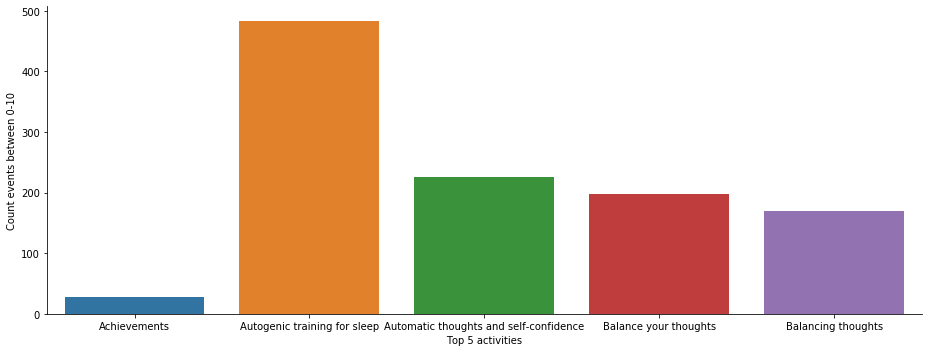

In [13]:
import seaborn as sns
import matplotlib as plt
a = df2[df2['hour_cat']=='0-10'][:5]
fig = sns.catplot(x="activity", y="count", kind="bar", data =a, aspect=2.6)
fig.set_axis_labels('Top 5 activities', 'Count events between 0-10')

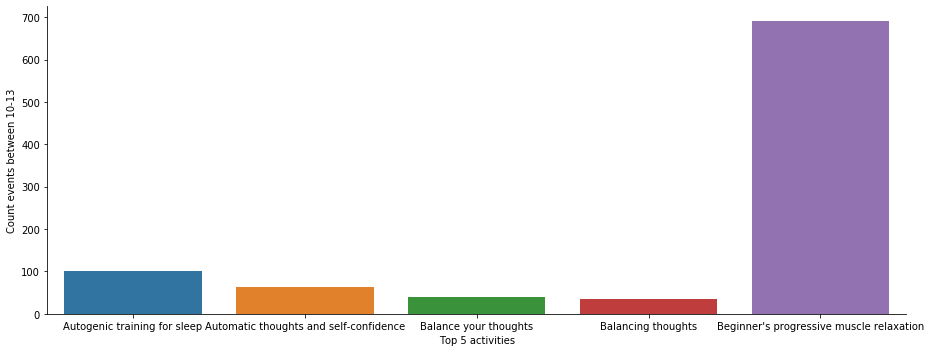

In [15]:
b = df2[df2['hour_cat']=='10-13'][:5]
fig = sns.catplot(x="activity", y="count", kind="bar", data =b, aspect=2.6)
fig.set_axis_labels('Top 5 activities', 'Count events between 10-13')

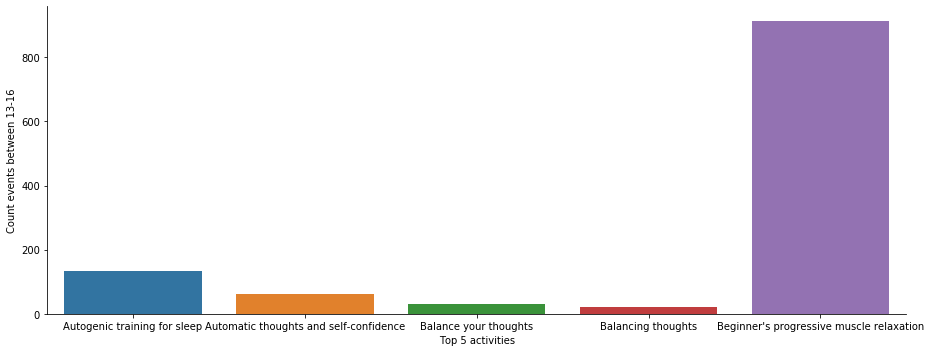

In [16]:
c = df2[df2['hour_cat']=='13-16'][:5]
fig = sns.catplot(x="activity", y="count", kind="bar", data =c, aspect=2.6)
fig.set_axis_labels('Top 5 activities', 'Count events between 13-16')

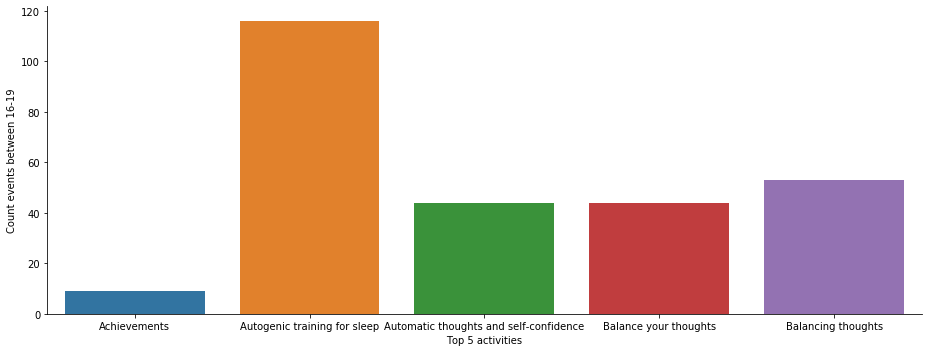

In [17]:
d = df2[df2['hour_cat']=='16-19'][:5]
fig = sns.catplot(x="activity", y="count", kind="bar", data =d, aspect=2.6)
fig.set_axis_labels('Top 5 activities', 'Count events between 16-19')

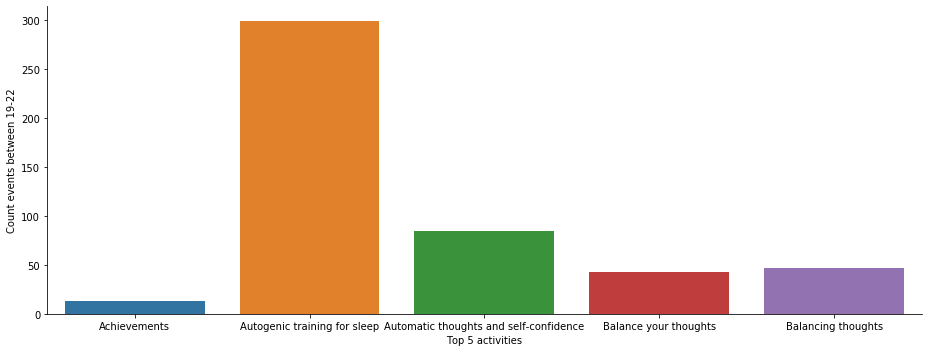

In [18]:
e = df2[df2['hour_cat']=='19-22'][:5]
fig = sns.catplot(x="activity", y="count", kind="bar", data =e, aspect=2.6)
fig.set_axis_labels('Top 5 activities', 'Count events between 19-22')

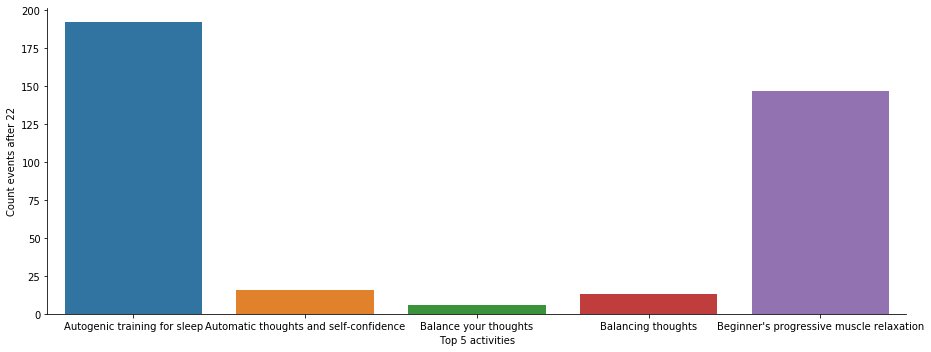

In [19]:
f = df2[df2['hour_cat']=='after 22'][:5]
fig = sns.catplot(x="activity", y="count", kind="bar", data =f, aspect=2.6)
fig.set_axis_labels('Top 5 activities', 'Count events after 22')

In [28]:
df3 = df.groupby(['activity', 'userId'])
df3 = df3['date'].nunique().reset_index(name="count")
df3.head()

,activity,userId,count
0,Achievements,2397e1e3-e7b4-459a-82c6-c8a69cdc7031,1
1,Achievements,54d3e190-ee81-4801-8b35-b484123f0080,1
2,Achievements,696e2ae2-c892-4f43-aa0c-8336bd353d45,2
3,Achievements,8e8e3863-041e-497a-8544-107efdb3d5cb,1
4,Achievements,df17bd69-9d0f-4469-bbc5-22f43ddbfc03,1


In [29]:
df3.sort_values(['count'], ascending = False)

,activity,userId,count
6696,Keeping a thought record,a03308ca-fbaf-4265-8257-b6ecf7ec4d40,24
8593,Positive thinking - people,98f3942d-c356-48c2-946e-02f91726e9b7,22
8088,Positive thinking - achievements,98f3942d-c356-48c2-946e-02f91726e9b7,22
8322,Positive thinking - gratitude,98f3942d-c356-48c2-946e-02f91726e9b7,21
14410,Waves,a7208087-c10f-4080-8b6a-e9738a530a54,21
...,...,...,...
5916,Keep stress in check while working from home,67b53dc2-8142-4ad8-a85a-662bae3072ec,1
5917,Keep stress in check while working from home,68edcc87-a82f-499d-941b-d1b4cd2838be,1
5918,Keep stress in check while working from home,6a544474-46d5-4204-a65f-f496c06d6667,1
5920,Keep stress in check while working from home,6baa51d5-fc8c-4ace-b158-06de0d641748,1


In [75]:
activities = df3.groupby('activity')
activities = activities['count'].mean().reset_index(name="mean_repetition")
activities.sort_values(['mean_repetition'], ascending = False)

,activity,mean_repetition
30,Keeping a thought record,3.078125
40,Positive thinking - gratitude,2.622642
39,Positive thinking - achievements,2.441088
41,Positive thinking - people,2.359116
84,Working on your bad habits,2.333333
...,...,...
35,Moving forward,1.095238
37,Myths about sleep,1.041667
9,Challenging thoughts on sleep,1.000000
56,Reviewing your bad sleep habits,1.000000


In [35]:
df_repetitions = df3[df3['count']>= 5]
df_repetitions.sort_values(['count'], ascending = False)

,activity,userId,count
6696,Keeping a thought record,a03308ca-fbaf-4265-8257-b6ecf7ec4d40,24
8593,Positive thinking - people,98f3942d-c356-48c2-946e-02f91726e9b7,22
8088,Positive thinking - achievements,98f3942d-c356-48c2-946e-02f91726e9b7,22
8322,Positive thinking - gratitude,98f3942d-c356-48c2-946e-02f91726e9b7,21
14410,Waves,a7208087-c10f-4080-8b6a-e9738a530a54,21
...,...,...,...
4872,Expansion,42735b08-ef07-42c6-aa3c-34044f8635ac,5
4804,Expansion,25dc8ef7-88f9-4cb8-809d-5eaa8e9557ca,5
9326,Progressive muscle relaxation for sleep,967ebdad-0c6e-40f7-8363-2fedf955c8cb,5
4793,Expansion,1dc772d3-85c2-4866-908e-abfcc543c5d0,5


In [36]:
df_repetitions['userId'].nunique()

245

In [37]:
df_repetitions['activity'].nunique()

52

In [67]:
df_repetitions[df_repetitions['activity']=='Keeping a thought record']['userId'].nunique()

174

In [74]:
df_repetitions[df_repetitions['activity']=='Positive thinking - gratitude']['userId'].nunique()

23

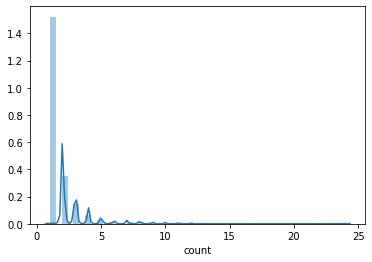

In [45]:
sns.distplot(df3['count'])

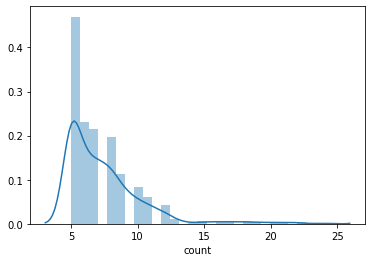

In [46]:
sns.distplot(df_repetitions['count'])

In [76]:
thoughts = df.copy()

In [78]:
thoughts = thoughts[thoughts['activity']=='Keeping a thought record']

In [103]:
thoughts

,userId,createdAt,data,date,activity,hour,hour_cat
41,ed0d77df-085b-418b-8490-86aaed92bf3c,2020-05-02 07:51:36.937897+00:00,"(Keeping a thought record,)",2020-05-02,Keeping a thought record,7,0-10
45,ed0d77df-085b-418b-8490-86aaed92bf3c,2020-05-02 07:51:40.080784+00:00,"(Keeping a thought record,)",2020-05-02,Keeping a thought record,7,0-10
47,ed0d77df-085b-418b-8490-86aaed92bf3c,2020-05-02 07:51:40.126710+00:00,"(Keeping a thought record,)",2020-05-02,Keeping a thought record,7,0-10
48,ed0d77df-085b-418b-8490-86aaed92bf3c,2020-05-02 07:51:41.165238+00:00,"(Keeping a thought record,)",2020-05-02,Keeping a thought record,7,0-10
124,ed0d77df-085b-418b-8490-86aaed92bf3c,2020-05-02 07:51:57.242390+00:00,"(Keeping a thought record,)",2020-05-02,Keeping a thought record,7,0-10
...,...,...,...,...,...,...,...
615998,3016f096-50d6-4613-ac4e-ebd984abcdaf,2020-02-14 13:13:20.813516+00:00,"(Keeping a thought record,)",2020-02-14,Keeping a thought record,13,10-13
616042,43ee2dde-e56e-4f74-b4db-1a48f84f712e,2020-04-08 05:22:26.185833+00:00,"(Keeping a thought record,)",2020-04-08,Keeping a thought record,5,0-10
616316,e7fc9906-64c5-4a13-8b05-2d4b3ca4beb7,2020-03-31 19:49:12.272790+00:00,"(Keeping a thought record,)",2020-03-31,Keeping a thought record,19,16-19
616317,e7fc9906-64c5-4a13-8b05-2d4b3ca4beb7,2020-03-31 19:49:14.248226+00:00,"(Keeping a thought record,)",2020-03-31,Keeping a thought record,19,16-19


In [132]:
import numpy as np
df4 = thoughts.groupby(['activity', 'userId'])['hour'].agg([np.mean, np.std]).reset_index()
df4.head()

,activity,userId,mean,std
0,Keeping a thought record,,11.444444,5.664465
1,Keeping a thought record,000d4f52-13dc-4600-9b02-3527dd646bc5,6.000000,0.000000
2,Keeping a thought record,0084bd82-3041-413d-ae1c-d7f39b2bdfe9,16.000000,0.000000
3,Keeping a thought record,01021dae-990a-4713-b087-a4208dde3f3d,15.500000,0.707107
4,Keeping a thought record,0115f360-76c2-4bf3-8874-bc214f699203,6.000000,0.000000


In [133]:
days = thoughts.groupby(['activity', 'userId'])
days = days['date'].nunique().reset_index(name='total_days')
days.set_index('userId')
days.head()

,activity,userId,total_days
0,Keeping a thought record,,5
1,Keeping a thought record,000d4f52-13dc-4600-9b02-3527dd646bc5,1
2,Keeping a thought record,0084bd82-3041-413d-ae1c-d7f39b2bdfe9,1
3,Keeping a thought record,01021dae-990a-4713-b087-a4208dde3f3d,2
4,Keeping a thought record,0115f360-76c2-4bf3-8874-bc214f699203,1


In [134]:
df4['total_days'] = days['total_days']

In [135]:
df4 = df4[df4['total_days']>= 5]
df4.sort_values(['total_days'], ascending = False)

,activity,userId,mean,std,total_days
466,Keeping a thought record,a03308ca-fbaf-4265-8257-b6ecf7ec4d40,13.949275,4.193012,24
735,Keeping a thought record,f5ff9aca-0969-432b-994f-e3ef1649ad04,15.785714,7.397845,20
440,Keeping a thought record,967ebdad-0c6e-40f7-8363-2fedf955c8cb,12.263158,3.084405,13
555,Keeping a thought record,bdc6fefe-565c-42fc-9252-a574a41399b7,9.707692,4.622906,12
187,Keeping a thought record,3b674a79-3c21-4311-8de3-3c090a53e4ed,16.867188,5.553421,12
...,...,...,...,...,...
602,Keeping a thought record,cbc76578-b3af-407e-b1b1-656eb08a9c7e,10.983193,6.301712,5
484,Keeping a thought record,a6a9b40e-58a7-41ad-9c0b-9a225b7aa589,13.975000,2.118145,5
586,Keeping a thought record,c6002bc7-b040-4729-8cbd-431ef22beb5b,18.333333,3.622023,5
502,Keeping a thought record,ad095232-32f5-4728-8c08-ebe8e3916bc7,5.833333,7.391216,5


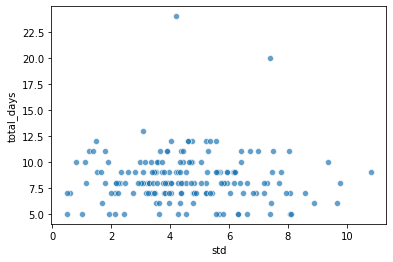

In [140]:
ax = sns.scatterplot(x="std", y="total_days", data=df4, alpha = 0.7)

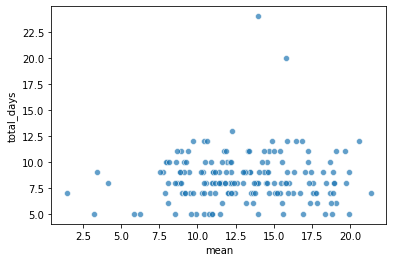

In [142]:
ax = sns.scatterplot(x="mean", y="total_days", data=df4, alpha = 0.7)